# PyTorch Spiral multi-class classification data

In this project, we are going to build a `PyTorch model powered by Non-linearity` to classify multi-class points in dataset shaped as Spiral

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install torchmetrics

In [3]:
import requests
from pathlib import Path

# download helper functions from learn-pytorch repo
if Path('helper_functions.py').is_file():
  print('File exists!!')
else:
  print('Downloading helper functions!')
  request = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py')
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)

File exists!!


In [4]:
from helper_functions import plot_decision_boundary
import torchmetrics

In [5]:
torch.__version__

'2.1.0+cu118'

## Generate our Spiral Data (from scratch)

In [7]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 500 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

In [8]:
X[:5], X.shape, y[:5], y.shape

(tensor([[-0.0000e+00,  0.0000e+00],
         [-1.4222e-04,  1.9990e-03],
         [ 4.0866e-05,  4.0078e-03],
         [ 1.8680e-03,  5.7144e-03],
         [ 3.0005e-04,  8.0104e-03]]),
 torch.Size([1500, 2]),
 tensor([0, 0, 0, 0, 0]),
 torch.Size([1500]))

### Splitting into Train and test sets

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([1200, 2]),
 torch.Size([1200]),
 torch.Size([300, 2]),
 torch.Size([300]))

In [10]:
X_train.dtype, y_test.dtype

(torch.float32, torch.int64)

### Plotting our Data (getting visual..)

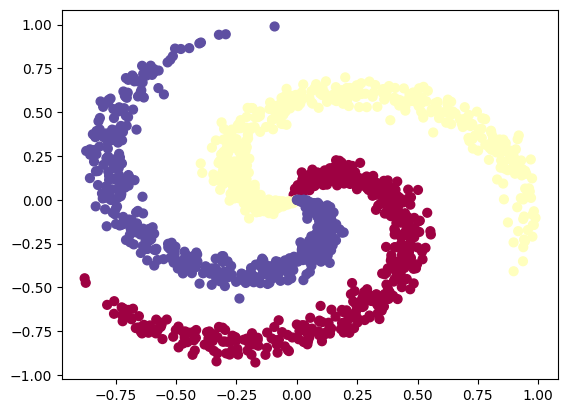

In [11]:
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

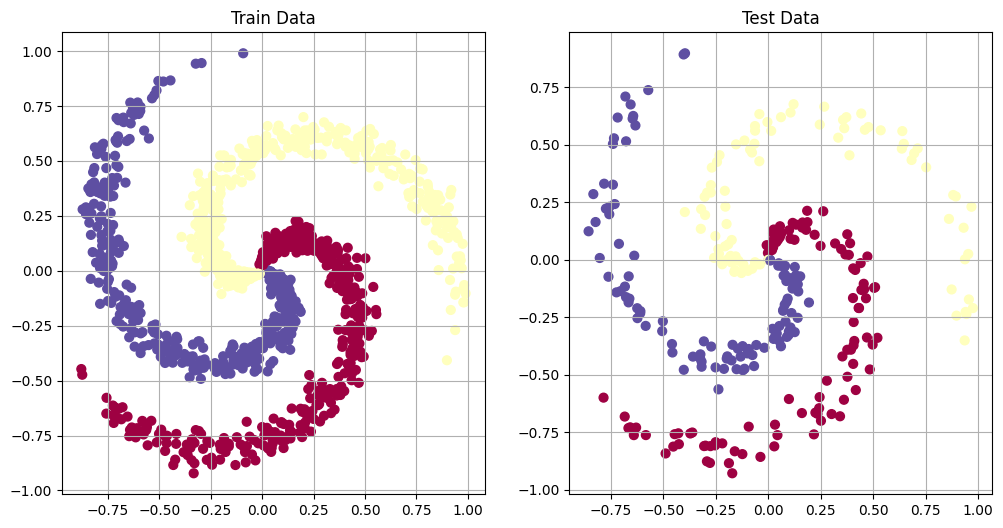

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train Data')
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=40, cmap=plt.cm.Spectral)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Test Data')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=40, cmap=plt.cm.Spectral)
plt.grid()
plt.show()

## Construct a PyTorch model

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [14]:
from torch import nn

class SpiralModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # create a linear stack of layers
    self.linear_stack = nn.Sequential(
        nn.Linear(in_features=2, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64, out_features=32),
        nn.ReLU(),
        nn.Linear(in_features=32, out_features=3),
    )

  def forward(self, X:torch.tensor) -> torch.tensor:
    return self.linear_stack(X)

model = SpiralModelV0().to(device)
model

SpiralModelV0(
  (linear_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=3, bias=True)
  )
)

### Set up Loss function, Optimizer and accuracy function

In [15]:
# Create an instance of CategoryEntropyLoss
loss_fn = torch.nn.CrossEntropyLoss()

# Intiailze Optimizer with model parameters
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)

### Making predictions with our model

In [16]:
with torch.inference_mode():
  un_y_logits = model(X_test.to(device))
un_y_logits[:5]

tensor([[0.1879, 0.1077, 0.0879],
        [0.1889, 0.1087, 0.0905],
        [0.1796, 0.1126, 0.0803],
        [0.1794, 0.1121, 0.0801],
        [0.1791, 0.1145, 0.0782]], device='cuda:0')

In [17]:
un_y_probs = torch.softmax(un_y_logits, dim=1)
un_y_probs[:5]

tensor([[0.3536, 0.3264, 0.3200],
        [0.3535, 0.3262, 0.3203],
        [0.3520, 0.3292, 0.3188],
        [0.3521, 0.3291, 0.3188],
        [0.3519, 0.3299, 0.3181]], device='cuda:0')

In [18]:
un_y_preds = torch.argmax(un_y_probs, dim=1)
un_y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [19]:
# Calculate accuracy - out of 100 how many correct ones did our model get
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = correct/len(y_pred) * 100
  return acc

## Building a Training & Testing Loop for our model

In [25]:
EPOCHS = 1000

# set up loss and epoch tracking variables
epoch_list = []
train_loss_val, test_loss_val = [], []

# Convert data to use GPU (for faster computations)
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Iterate through epochs
for epoch in range(EPOCHS):
  # set model to train mode
  model.train()

  # Forward Propagation
  y_logits = model(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  # Calculate loss and accuracy
  train_loss = loss_fn(y_logits, y_train)
  train_acc = accuracy_fn(y_train, y_preds)

  # Clear all gradient calculations from previous epoch
  optimizer.zero_grad()
  # Backpropagation
  train_loss.backward()
  # Gradient-Descent
  optimizer.step()

  # Make predictions and calculate test loss and accuracy
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_preds)

  # Update epoch, loss value to tracking variables
  epoch_list.append(epoch)
  train_loss_val.append(train_loss.cpu().detach().numpy())
  test_loss_val.append(test_loss.cpu().detach().numpy())

  if epoch % 100 == 0:
    print(f'Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:2f} | Test loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 | Train Loss: 1.09521 | Train Accuracy: 33.000000 | Test loss: 1.09470 | Test Accuracy: 34.67
Epoch: 100 | Train Loss: 0.72025 | Train Accuracy: 56.250000 | Test loss: 0.74958 | Test Accuracy: 54.67
Epoch: 200 | Train Loss: 0.52900 | Train Accuracy: 68.500000 | Test loss: 0.56906 | Test Accuracy: 66.33
Epoch: 300 | Train Loss: 0.32736 | Train Accuracy: 85.750000 | Test loss: 0.33637 | Test Accuracy: 87.33
Epoch: 400 | Train Loss: 0.22605 | Train Accuracy: 91.500000 | Test loss: 0.22270 | Test Accuracy: 89.67
Epoch: 500 | Train Loss: 0.14590 | Train Accuracy: 95.416667 | Test loss: 0.13281 | Test Accuracy: 95.33
Epoch: 600 | Train Loss: 0.10701 | Train Accuracy: 96.833333 | Test loss: 0.08958 | Test Accuracy: 97.00
Epoch: 700 | Train Loss: 0.08233 | Train Accuracy: 97.250000 | Test loss: 0.06626 | Test Accuracy: 98.33
Epoch: 800 | Train Loss: 0.06720 | Train Accuracy: 97.666667 | Test loss: 0.05309 | Test Accuracy: 98.67
Epoch: 900 | Train Loss: 0.05545 | Train Accuracy: 98.000

## Evaluating our PyTorch model

* Checking final accuracy
* Visualizing the loss curves
* Plotting Decision Boundary made by PyTorch model, to classify the data
* Verifying with differnt classification metrics inside `torchmetrics`

In [26]:
with torch.inference_mode():
  y_logits = model(X_test)
y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
y_preds[:10]

tensor([2, 2, 0, 0, 0, 1, 2, 1, 2, 0], device='cuda:0')

In [29]:
y_test[:10]

tensor([2, 2, 0, 0, 0, 1, 2, 1, 2, 0], device='cuda:0')

In [30]:
print(f'Test Loss: {loss_fn(y_logits, y_test)}')
print(f'Test Accuracy: {accuracy_fn(y_test, y_preds)}')

Test Loss: 0.02847364731132984
Test Accuracy: 99.66666666666667


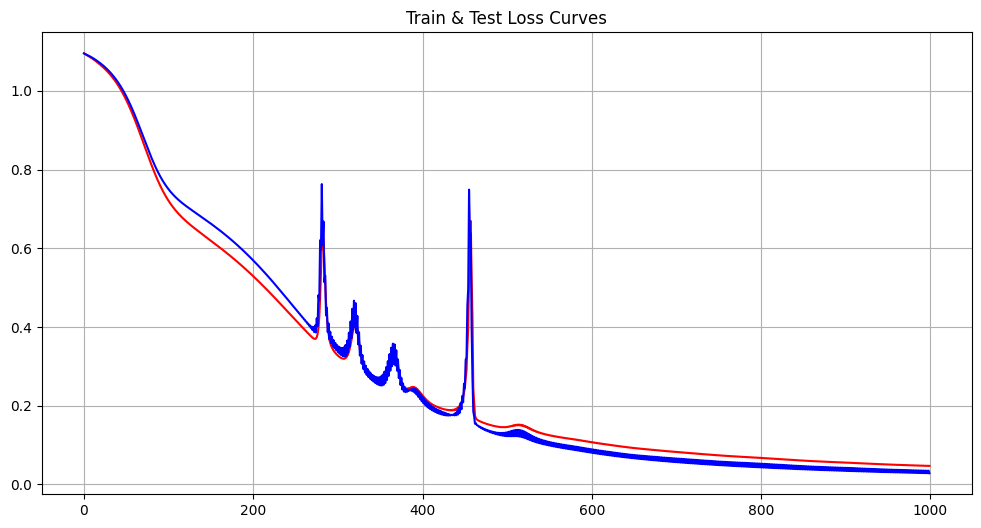

In [34]:
plt.figure(figsize=(12, 6))
plt.title('Train & Test Loss Curves')
plt.plot(epoch_list, train_loss_val, label='Train loss', c='red')
plt.plot(epoch_list, test_loss_val, label='Test Loss', c='blue')
plt.grid()
plt.show()

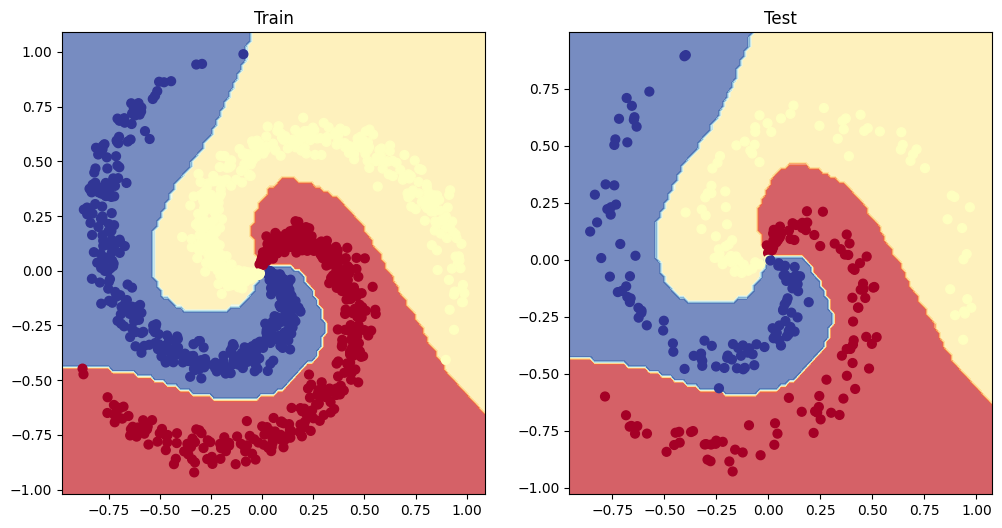

In [35]:
# plot decision boundary of model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

In [38]:
from torchmetrics import Accuracy, Precision, Recall, F1Score

def torch_metrics(preds, target):

  torchmetric_acc = Accuracy(task="multiclass", num_classes=4).to(device)
  acc = torchmetric_acc(preds, target)

  torchmetric_precision = Precision(task="multiclass", num_classes=4, average='macro').to(device)
  precision = torchmetric_precision(preds, target)

  torchmetric_recall = Recall(task="multiclass", num_classes=4, average='macro').to(device)
  recall = torchmetric_recall(preds, target)

  torchmetric_f1 = F1Score(task="multiclass", num_classes=4, average='macro').to(device)
  f1 = torchmetric_f1(preds, target)

  return acc, precision, recall, f1

acc, prec, recall, f1_score = torch_metrics(preds=y_preds, target=y_test)
print(f'Accuracy: {acc*100}% \nPrecision: {prec*100}% \nRecall: {recall*100}% \nF1 Score: {f1_score*100}%')

Accuracy: 99.66666412353516% 
Precision: 99.69969940185547% 
Recall: 99.6124038696289% 
F1 Score: 99.65424346923828%


## Saving and re-loading our model

In [39]:
# saving our spiral mutliclass classification PyTorch model
torch.save(model.state_dict(), "spiral_classification_model.pt")

In [41]:
# loading our model
loaded_model = SpiralModelV0().to(device)
loaded_model.load_state_dict(torch.load("spiral_classification_model.pt"))

<All keys matched successfully>

In [42]:
with torch.inference_mode():
  loaded_y_preds = torch.argmax(torch.softmax(loaded_model(X_test), dim=1), dim=1)
loaded_y_preds == y_preds

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

In [44]:
acc, prec, recall, f1_score = torch_metrics(preds=y_preds, target=y_test)
print(f'Accuracy: {acc*100}% \nPrecision: {prec*100}% \nRecall: {recall*100}% \nF1 Score: {f1_score*100}%')

Accuracy: 99.66666412353516% 
Precision: 99.69969940185547% 
Recall: 99.6124038696289% 
F1 Score: 99.65424346923828%
